In [1]:
import numpy as np
import scipy.fft as sp_fft

class JointChannelOF:

    def __init__(self, templates, noise_psds, sampling_frequency):
        """
        templates: list of 1D numpy arrays, one per channel
        noise_psds: list of 1D numpy arrays, one per channel
        """
        self._sampling_frequency = sampling_frequency
        self._n_channels = len(templates)
        self._length = len(templates[0])

        self.set_templates(templates)
        self.set_noise_psds(noise_psds)

    def set_templates(self, templates):
        self._templates = templates
        self._template_ffts = [sp_fft.rfft(tpl) / self._sampling_frequency for tpl in templates]
        self._update_kernels()

    def set_noise_psds(self, noise_psds):
        self._noise_psds = noise_psds

        self._inv_psds = []
        for psd in noise_psds:
            inv_psd = np.zeros_like(psd)
            inv_psd[1:] = 1.0 / (psd[1:] + 1e-30)
            if self._length % 2 == 0:
                inv_psd[-1] = 1.0 / (psd[-1] + 1e-30)
            inv_psd[0] = 0.0
            self._inv_psds.append(inv_psd)

        self._update_kernels()

    def _update_kernels(self):
        if hasattr(self, '_template_ffts') and hasattr(self, '_inv_psds'):
            self._kernels = []
            norms = []
            for tpl_fft, inv_psd in zip(self._template_ffts, self._inv_psds):
                kernel = tpl_fft.conjugate() * inv_psd
                norm = np.real(np.sum(kernel * tpl_fft)) * self._sampling_frequency / self._length
                self._kernels.append(kernel)
                norms.append(norm)

            self._kernel_normalization = np.sum(norms)

    def fit_with_shift(self, traces, allowed_shift_range=[0, 0]):
        """
        traces: list of 1D numpy arrays, one per channel
        """
        filtered_traces_fft = []
        trace_ffts = []
        chisq0_total = 0.0

        for trace, kernel, norm, inv_psd in zip(
            traces, self._kernels,
            [np.real(np.sum(k * t)) * self._sampling_frequency / self._length for k, t in zip(self._kernels, self._template_ffts)],
            self._inv_psds
        ):
            tr_fft = sp_fft.rfft(trace) / self._sampling_frequency
            trace_ffts.append(tr_fft)
            filtered = kernel * tr_fft / norm
            filtered_traces_fft.append(filtered)

            chisq0 = np.real(np.vdot(tr_fft, tr_fft * inv_psd)) * self._sampling_frequency / self._length
            chisq0_total += chisq0

        # Sum of inverse FFTs of all channels => joint A(t0)
        amp_series = 0.5 * sum(sp_fft.irfft(filt) * self._sampling_frequency for filt in filtered_traces_fft)

        chisq_series = chisq0_total - amp_series**2 * self._kernel_normalization

        if allowed_shift_range is None:
            ind = np.arange(len(chisq_series))
        else:
            start = (self._length + allowed_shift_range[0]) % self._length
            stop = (allowed_shift_range[1] + 1) % self._length
            if start < stop:
                ind = np.arange(start, stop)
            else:
                ind = np.concatenate((np.arange(start, self._length), np.arange(0, stop)))

        best_ind = ind[np.argmin(chisq_series[ind])]
        amp = amp_series[best_ind]
        chisq = chisq_series[best_ind] / (self._length - 3)
        t0 = best_ind if best_ind < self._length // 2 else best_ind - self._length

        return amp, chisq, t0


In [2]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator
from trace_IO import *
from OF_trigger import *

import matplotlib.pyplot as plt

def plot_trace_set(trace_set, offset=50):
    """
    Plot a single trace set (shape: 54 x N) with vertical offsets.

    Parameters:
    - trace_set: ndarray, shape (54, N)
    - offset: float, vertical offset between channels
    """
    n_channels, n_samples = trace_set.shape

    for i in range(n_channels):
        color = 'r' if i > 44 else 'b'
        plt.plot(np.arange(n_samples), trace_set[i] + i * offset, color=color, lw=0.2)

    plt.xlabel("Sample Index")
    plt.yticks([])
    plt.ylim(-10, offset * n_channels)
    plt.title("Trace Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

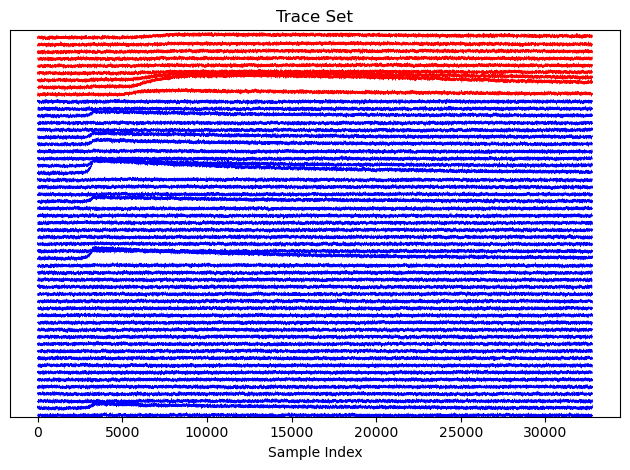

In [10]:
trace = ts.generate(E=1500, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=True, phonon_only=False)

plot_trace_set(trace[0])

In [ ]:
trace = ts.generate(E=0, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=True, phonon_only=False)

fs = 3906250
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# 1. Extract 9 vacuum channels
trace_vacuum = trace[0][45:]  # shape: (9, 32768)

# 2. Prepare replicated template and PSD
templates = [ch45_template] + [ch46_template] *8     # template: 1D array, e.g., (32768,)
psds = [noise_psd] * 9         # noise_psd: 1D array, e.g., (16385,)

# 3. Initialize JointChannelOF
of = JointChannelOF(templates=templates, noise_psds=psds, sampling_frequency=fs)

# 4. Fit trace
amp, chisq, t0 = of.fit_with_shift(trace_vacuum)
print(f"Joint Amplitude: {amp:.4f}, Chi²: {chisq:.4f}, t₀: {t0} samples")


UV template Amplitude: -2.5302, Chi²: 1.9585, t₀: -1884 samples


Processing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing traces: 100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]



Amplitude stats over 1000 traces:
Mean: 0.0751, Std: 2.2453, Min: -6.4357, Max: 6.9406


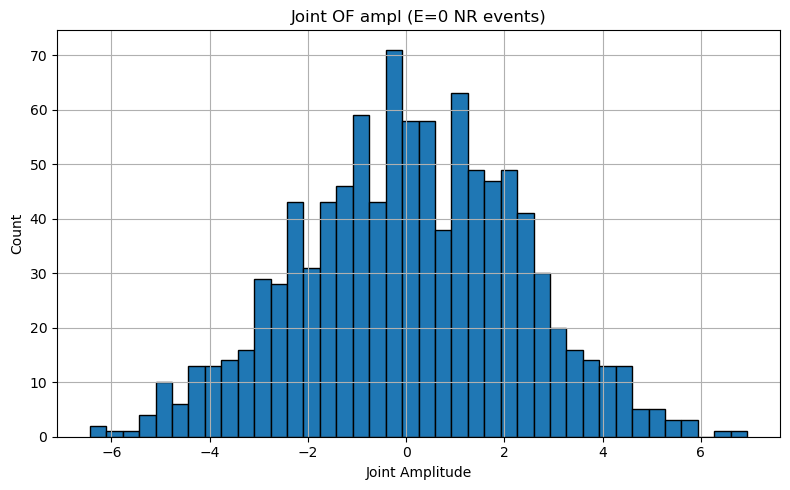

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# Initialize constants
fs = 3906250
n_events = 1000

# Load templates and PSD
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Prepare templates and PSDs for 9 vacuum channels
templates = [ch45_template] + [ch46_template] * 8
psds = [noise_psd] * 9

# Initialize JointChannelOF
of = JointChannelOF(templates=templates, noise_psds=psds, sampling_frequency=fs)

# Collect amplitudes
amplitudes = []

for _ in tqdm(range(n_events), desc="Processing traces"):
    trace = ts.generate(E=0, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=True, phonon_only=False)
    trace_vacuum = trace[0][45:]  # 9 vacuum channels
    amp, chisq, t0 = of.fit_with_shift(trace_vacuum)
    amplitudes.append(amp)

# Convert to numpy array
amplitudes = np.array(amplitudes)

# Print stats
mean_amp = np.mean(amplitudes)
std_amp = np.std(amplitudes)
min_amp = np.min(amplitudes)
max_amp = np.max(amplitudes)

print(f"\nAmplitude stats over {n_events} traces:")
print(f"Mean: {mean_amp:.4f}, Std: {std_amp:.4f}, Min: {min_amp:.4f}, Max: {max_amp:.4f}")

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(amplitudes, bins=40, edgecolor='black')
plt.title("Joint OF ampl (E=0 NR events)")
plt.xlabel("Joint Amplitude")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:

sampling_frequency = 3906250
template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

In [13]:
# Initialize lists to hold fit results
amplitudes = []
chi2s = []
t0s = []

# Loop over all 54 channels
for i in range(45, 54):
    ampl, chi2, t0 = trigger.fit_with_shift(trace[0][i])
    amplitudes.append(ampl)
    chi2s.append(chi2)
    t0s.append(t0)
    print(f"Trace {i}: Amplitude = {ampl:.4f}, Chi2 = {chi2:.4f}, t0 = {t0:.4f}")

# Optionally convert to NumPy arrays
import numpy as np
amplitudes = np.array(amplitudes)
chi2s = np.array(chi2s)
t0s = np.array(t0s)


Trace 45: Amplitude = 1.4663, Chi2 = 0.2178, t0 = -1601.0000
Trace 46: Amplitude = -2.0917, Chi2 = 0.2178, t0 = 233.0000
Trace 47: Amplitude = -1.8557, Chi2 = 0.2177, t0 = 1534.0000
Trace 48: Amplitude = -1.4859, Chi2 = 0.2178, t0 = -532.0000
Trace 49: Amplitude = 1.5281, Chi2 = 0.2177, t0 = 1952.0000
Trace 50: Amplitude = -1.2477, Chi2 = 0.2178, t0 = -383.0000
Trace 51: Amplitude = -0.7096, Chi2 = 0.2177, t0 = 1167.0000
Trace 52: Amplitude = 1.8532, Chi2 = 0.2175, t0 = 1513.0000
Trace 53: Amplitude = 1.5903, Chi2 = 0.2177, t0 = -1814.0000
